# data-preprocessing

Preprocessing procedures for raw data.

Warning: can eat up to 10 GB RAM while processing and filtering raw OSM data.

Requires:
1. `data/raw/osm.zip` (can be downloaded [here](https://drive.google.com/drive/folders/1Z_oSs5Vk4LSxwjc10iVa9mazBvWHuCf6?usp=sharing))
2. `data/raw/spb_routes.csv`

Produces:
1. `data/preprocessed/infrastructure.json`
2. `data/preprocessed/stops.json`
3. `data/preprocessed/routes.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
import json
from itertools import chain
from typing import Tuple, List, Optional, Set
from zipfile import ZipFile

import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

from myutils.spatial import get_earth_distances
from myutils.json import save_json

from config import raw_osm_data_fpath, raw_routes_data_fpath, \
    infrastructure_fpath, stops_fpath, routes_fpath
from ptn.preprocessing.osm import assign_infrastructure_types

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-deep')

## SPb routes

In [3]:
raw_routes = pd.read_csv(raw_routes_data_fpath)

raw_routes = raw_routes.rename(columns={'route_id': 'id', 'route_short_name': 'name',
                                        'transport_type': 'type'})

raw_routes['type'] = raw_routes['type'].map(
    {'Автобус': 'bus', 'Трамвай': 'tram', 'Троллейбус': 'trolley'})

raw_routes['lat'] = raw_routes['coordinates'].apply(lambda x: float(x.split(',')[0]))
raw_routes['lon'] = raw_routes['coordinates'].apply(lambda x: float(x.split(',')[1]))

raw_routes.head(2)

,number,id,name,route_long_name,type,direction,stop_id,next_stop,stop_distance,stop_name,coordinates,lat,lon
0,1,1125,А,Р. Оккервиль - Ул. Коллонтай,tram,1,16396,16367,0.85,"Конечная станция ""Река Оккервиль""","59.9088808952478,30.4946709",59.908881,30.494671
1,2,1125,А,Р. Оккервиль - Ул. Коллонтай,tram,1,16367,16371,0.40,Пр. Солидарности,"59.9118566503083,30.4998817",59.911857,30.499882


In [4]:
stops = raw_routes.drop_duplicates('stop_id')\
    .drop(columns=['id', 'name'])\
    .rename(columns={'stop_id': 'id', 'stop_name': 'name'})\
    .reset_index(drop=True)

stops.head(2)

,number,route_long_name,type,direction,id,next_stop,stop_distance,name,coordinates,lat,lon
0,1,Р. Оккервиль - Ул. Коллонтай,tram,1,16396,16367,0.85,"Конечная станция ""Река Оккервиль""","59.9088808952478,30.4946709",59.908881,30.494671
1,2,Р. Оккервиль - Ул. Коллонтай,tram,1,16367,16371,0.40,Пр. Солидарности,"59.9118566503083,30.4998817",59.911857,30.499882


In [5]:
routes = []

for route_id in tqdm(raw_routes['id'].unique()):
    for direction in raw_routes.loc[raw_routes['id'] == route_id, 'direction'].unique():
        mask = (raw_routes['id'] == route_id) & (raw_routes['direction'] == direction)
        raw_route = raw_routes[mask]
        
        assert raw_route['type'].nunique() == 1
        route_type = raw_route.iloc[0]['type']

        assert raw_route['name'].nunique() == 1
        name = raw_route.iloc[0]['name']
        
        assert raw_route['stop_id'].nunique() == raw_route.shape[0]

        next_stops = raw_route.set_index('stop_id')['next_stop']

        start = set(next_stops.index) - set(next_stops.values)
        
        if len(start) == 0:
            assert set(next_stops.index) == set(next_stops.values)  # circular route
            
            start = next_stops.index[0]
            route = [start]
            
            while True:
                next_ = next_stops[route[-1]]
                
                if next_ in route:
                    break
                    
                route.append(next_)
        
        else:
            assert len(start) == 1
            start = start.pop()

            route = [start]

            while route[-1] in next_stops.index:
                route.append(next_stops[route[-1]])

        routes.append({
            'name': name,
            'type': route_type,
            'direction': direction,
            'stops': route,
            'id': route_id,
        })
        
routes = pd.DataFrame(routes)

routes.head(2)

100%|██████████| 643/643 [00:02<00:00, 288.00it/s]


,name,type,direction,stops,id
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125


In [6]:
route_stops = set(chain.from_iterable(routes['stops']))
stops_ = set(stops['id'].unique())

missing_stops = route_stops - stops_

len(missing_stops)

45

In [7]:
def remove_missing_stops(route: List[int]) -> List[int]:
    missing = set(route).intersection(missing_stops)
    
    if len(missing) == 0:
        return route
    
    assert len(missing) == 1
    missing = missing.pop()
    assert route.index(missing) == len(route) - 1
    
    return route[:-1]


routes['stops'] = routes['stops'].apply(remove_missing_stops)

routes.head(2)

,name,type,direction,stops,id
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125


## OSM

In [8]:
with ZipFile(raw_osm_data_fpath) as zipfile:
    raw_osm = []

    for fname in zipfile.namelist():
        with zipfile.open(fname, ) as file:
            raw_osm.extend(json.load(file)['elements'])

raw_osm = pd.DataFrame(raw_osm)

raw_osm = raw_osm.drop_duplicates(['type', 'id'])

raw_osm.head(2)

,type,id,lat,lon,tags,nodes,members
0,node,224873,60.179268,29.957429,NaN,NaN,NaN
1,node,224875,60.186004,29.948981,NaN,NaN,NaN


In [9]:
raw_osm['type'].shape

(16188634,)

In [10]:
x0, y0 = stops[['lon', 'lat']].min()
x1, y1 = stops[['lon', 'lat']].max()

# padding out by about 10 km each way
xpad = (x1 - x0) / 25
ypad = (y1 - y0) / 7

x0 -= xpad
x1 += xpad
y0 -= ypad
y1 += ypad

x0, x1, y0, y1

(28.876577076, 31.426889724, 59.434442459461785, 60.479614442928714)

In [11]:
mask = (raw_osm['lon'].isna() | ((raw_osm['lon'] >= x0) & (raw_osm['lon'] <= x1)))\
    & (raw_osm['lat'].isna() | ((raw_osm['lat'] >= y0) & (raw_osm['lat'] <= y1)))

raw_osm = raw_osm[mask].copy()

raw_osm.head(2)

,type,id,lat,lon,tags,nodes,members
0,node,224873,60.179268,29.957429,NaN,NaN,NaN
1,node,224875,60.186004,29.948981,NaN,NaN,NaN


In [12]:
raw_osm['type'].shape

(8494282,)

In [13]:
raw_osm['type'].value_counts()

node        6705108
way         1705227
relation      83947
Name: type, dtype: int64

In [14]:
node_coords = raw_osm.loc[raw_osm['type'] == 'node', ['id', 'lat', 'lon']].set_index('id')
assert node_coords.notna().all().all()

node_coords = dict(zip(node_coords.index.tolist(), map(tuple, node_coords.values.tolist())))

### Infrastructure objects

In [15]:
raw_osm['infrastructure_types'] = raw_osm['tags'].apply(assign_infrastructure_types)
raw_osm['n_infrastructure_types'] = raw_osm['infrastructure_types'].apply(len)

raw_osm['n_infrastructure_types'].value_counts()

0    8339341
1     152913
2       2006
3         22
Name: n_infrastructure_types, dtype: int64

In [16]:
mask = (raw_osm['n_infrastructure_types'] > 0) & (raw_osm['type'] != 'relation')

infrastructure = raw_osm[mask].copy()

infrastructure.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types
51184,node,243158032,59.899599,29.089534,"{'amenity': 'school', 'name': 'ДЮСШ'}",NaN,NaN,[education_research],1
86529,node,250691416,59.810319,28.993070,"{'historic': 'memorial', 'name': 'Мемориал «Бе...",NaN,NaN,[tourism],1


In [17]:
def get_name(tags: dict) -> str:
    if not isinstance(tags, dict):
        return
    
    name = tags.get('official_name', tags.get('name:ru', tags.get('name')))
    
    return name


infrastructure['name'] = infrastructure['tags'].apply(get_name)

infrastructure.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types,name
51184,node,243158032,59.899599,29.089534,"{'amenity': 'school', 'name': 'ДЮСШ'}",NaN,NaN,[education_research],1,ДЮСШ
86529,node,250691416,59.810319,28.993070,"{'historic': 'memorial', 'name': 'Мемориал «Бе...",NaN,NaN,[tourism],1,Мемориал «Берег мужественных»


In [18]:
all_nodes = set(node_coords.keys())

mask = infrastructure['nodes'].notna()
n_items = mask.sum()

to_remove = []

for i, row in tqdm(infrastructure[mask].iterrows(), total=n_items):
    nodes = set(row['nodes'])
    
    if len(nodes - all_nodes) > 0:
        to_remove.append(i)
        continue
    
    coords = np.array([node_coords[node] for node in nodes])
    lat, lon = coords.mean(axis=0)
    infrastructure.loc[i, 'lat'] = lat
    infrastructure.loc[i, 'lon'] = lon
    
    distances = get_earth_distances(coords, coords)
    diameter = distances.max()
    infrastructure.loc[i, 'diameter'] = diameter
    
infrastructure = infrastructure.drop(index=to_remove)

infrastructure.shape

100%|██████████| 101171/101171 [02:59<00:00, 564.29it/s]


(115130, 11)

/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


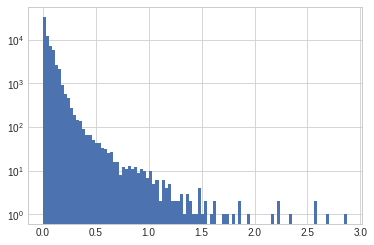

In [19]:
plt.hist(infrastructure['diameter'], bins=100)

plt.yscale('log');

In [20]:
(infrastructure['diameter'] > 0.25).mean()

0.013454355945452965

In [21]:
infrastructure.sort_values(by='diameter', ascending=False).iloc[0]['tags']

{'contact:website': 'http://www.seaport.spb.ru/about/structure/13/',
 'industrial': 'port',
 'landuse': 'industrial',
 'name': 'Первая стивидорная компания',
 'official_name': 'ОАО "Морской порт Санкт-Петербург"',
 'port': 'cargo'}

In [22]:
infrastructure['diameter'] = infrastructure['diameter'].fillna(0)

In [23]:
assert infrastructure[['lat', 'lon']].notna().all().all()
assert infrastructure['id'].nunique() == infrastructure.shape[0]

In [24]:
stop_coords = stops[['lat', 'lon']].values

infrastructure_coords = infrastructure[['lat', 'lon']]

distances = pd.Series({
    i: get_earth_distances(coords.values.reshape(1, -1), stop_coords).min()
    for i, coords in tqdm(infrastructure_coords.iterrows(), total=infrastructure_coords.shape[0])
})

to_remove = distances[distances > 2].index

infrastructure = infrastructure.drop(index=to_remove)

infrastructure.shape

100%|██████████| 115130/115130 [00:43<00:00, 2647.13it/s]


(89563, 11)

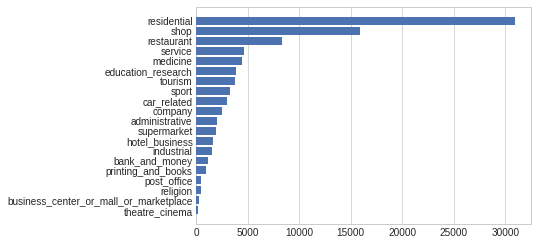

In [25]:
infrastructure_types = pd.Series(chain.from_iterable(infrastructure['infrastructure_types']))
infrastructure_type_counts = infrastructure_types.value_counts().sort_values()

plt.barh(
    infrastructure_type_counts.index,
    infrastructure_type_counts.values,
    zorder=5,
)

plt.grid(axis='y')

In [26]:
infrastructure_json = infrastructure\
    .drop(columns=['type', 'tags', 'nodes', 'members', 'n_infrastructure_types'])\
    .rename(columns={'infrastructure_types': 'types'})

infrastructure_json = [row.to_dict() for _, row in infrastructure_json.iterrows()]

len(infrastructure_json)

89563

In [27]:
save_json(infrastructure_json, infrastructure_fpath)

### Subway stations

In [28]:
def is_subway_entrance(tags: dict) -> bool:
    return isinstance(tags, dict) and tags.get('railway') == 'subway_entrance'


def get_subway_line_color(tags: dict) -> str:
    return tags.get('colour')


raw_osm['is_subway_entrance'] = raw_osm['tags'].apply(is_subway_entrance)

mask = raw_osm['is_subway_entrance'] & (raw_osm['type'] == 'node')
subway_entrances = raw_osm[mask].copy()

subway_entrances['name'] = subway_entrances['tags'].apply(get_name)
subway_entrances['line_color'] = subway_entrances['tags'].apply(get_subway_line_color)

subway_entrances.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types,is_subway_entrance,name,line_color
135865,node,348149970,60.050870,30.442688,"{'barrier': 'turnstile', 'colour': 'red', 'fee...",NaN,NaN,[],0,True,Девяткино - 2,red
7668773,node,4632523924,60.050666,30.442555,"{'colour': 'red', 'name': 'Девяткино - 2', 'na...",NaN,NaN,[],0,True,Девяткино - 2,red


In [29]:
station_names = ['Автово', 'Адмиралтейская', 'Академическая', 'Балтийская',
                 'Беговая', 'Бухарестская', 'Василеостровская', 'Владимирская',
                 'Волковская', 'Выборгская', 'Горьковская', 'Гостиный двор',
                 'Гражданский проспект', 'Достоевская', 'Дунайская', 'Елизаровская',
                 'Звенигородская', 'Звёздная', 'Зенит', 'Кировский завод',
                 'Комендантский проспект', 'Крестовский остров', 'Купчино',
                 'Ладожская', 'Ленинский проспект', 'Лесная', 'Лиговский проспект',
                 'Ломоносовская', 'Маяковская', 'Международная', 'Московская',
                 'Московские ворота', 'Нарвская', 'Невский проспект',
                 'Новочеркасская', 'Обводный канал', 'Обухово', 'Озерки',
                 'Парк Победы', 'Парнас', 'Петроградская', 'Пионерская',
                 'Площадь Александра Невского', 'Площадь Восстания', 'Площадь Ленина',
                 'Площадь Мужества', 'Политехническая', 'Приморская', 'Пролетарская',
                 'Проспект Большевиков', 'Проспект Ветеранов', 'Проспект Просвещения',
                 'Проспект Славы', 'Пушкинская', 'Рыбацкое', 'Садовая',
                 'Сенная площадь', 'Спасская', 'Спортивная', 'Старая Деревня',
                 'Технологический институт', 'Удельная', 'Улица Дыбенко',
                 'Фрунзенская', 'Чернышевская', 'Чкаловская', 'Чёрная речка',
                 'Шушары', 'Электросила', 'Девяткино']


def get_station_name(entrance_name: str) -> str:
    suitable_station_names = [name for name in station_names if entrance_name.startswith(name)]
    
    if len(suitable_station_names) != 1:
        raise ValueError('multiple or no station names for entrance ' + repr(entrance_name))
        
    return suitable_station_names[0]


subway_entrances['station_name'] = subway_entrances['name'].apply(get_station_name)

subway_entrances.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types,is_subway_entrance,name,line_color,station_name
135865,node,348149970,60.050870,30.442688,"{'barrier': 'turnstile', 'colour': 'red', 'fee...",NaN,NaN,[],0,True,Девяткино - 2,red,Девяткино
7668773,node,4632523924,60.050666,30.442555,"{'colour': 'red', 'name': 'Девяткино - 2', 'na...",NaN,NaN,[],0,True,Девяткино - 2,red,Девяткино


In [30]:
assert subway_entrances['line_color'].notna().all()
assert subway_entrances['station_name'].notna().all()

In [31]:
line_starts = {
    'blue': 'Парнас',
    'red': 'Девяткино',
    'green': 'Беговая',
    'orange': 'Улица Дыбенко',
    'purple': 'Комендантский проспект',
}

In [32]:
subway_stations = []

for line_color, station_name in subway_entrances[['line_color', 'station_name']].drop_duplicates().values:
    mask = (subway_entrances['line_color'] == line_color)\
        & (subway_entrances['station_name'] == station_name)
    
    station_entrances = subway_entrances[mask]
    coords = station_entrances[['lat', 'lon']].values
    lat, lon = coords.mean(axis=0)
    
    diameter = get_earth_distances(coords, coords).max()
    
    subway_stations.append({
        'line_color': line_color,
        'name': station_name,
        'lat': lat,
        'lon': lon,
        'diameter': diameter,
        'start': line_starts[line_color] == station_name,
    })
    
subway_stations = pd.DataFrame(subway_stations)

subway_stations['name'] = subway_stations['name'] + ' (' + subway_stations['line_color'] + ')'
subway_stations['id'] = subway_stations.index.tolist()
subway_stations['type'] = 'subway'

subway_stations.head(2)

,line_color,name,lat,lon,diameter,start,id,type
0,red,Девяткино (red),60.050325,30.442339,0.124599,True,0,subway
1,blue,Петроградская (blue),59.966286,30.311433,0.004227,False,1,subway


(30.187768395, 30.515850105000002, 59.80753091, 60.07958929)

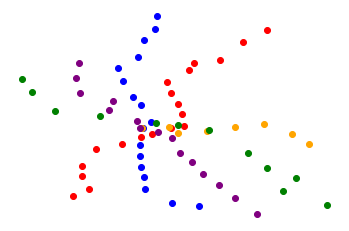

In [33]:
for color in subway_stations['line_color'].unique():
    values = subway_stations\
        .loc[subway_stations['line_color'] == color, ['lon', 'lat']]\
        .values
    
    plt.scatter(*values.T, color=color)
    
plt.axis('off')

### Subway routes

In [34]:
subway_routes = []

for color in subway_stations['line_color'].unique():
    line_stations = subway_stations[subway_stations['line_color'] == color]
    n_stations = line_stations.shape[0]
    
    coords = line_stations[['lat', 'lon']].values
    distances = get_earth_distances(coords, coords)
    distances[np.arange(n_stations), np.arange(n_stations)] = np.infty
    distances = pd.DataFrame(distances, index=line_stations['id'], columns=line_stations['id'])
    
    start = line_stations.loc[line_stations['start'], 'id']
    assert start.shape == (1,)
    start = start.iloc[0]
    
    route = [start]
        
    while True:
        closest_unvisited = distances\
            .loc[route[-1], ~distances.index.isin(route)]\
            .sort_values()
        
        if closest_unvisited.empty:
            break
        
        next_ = closest_unvisited.index[0]
        route.append(next_)
        
    name = color.capitalize() + ' line'
        
    subway_routes.append({
        'name': name,
        'type': 'subway',
        'direction': 1,
        'stops': route,
    })
    subway_routes.append({
        'name': name,
        'type': 'subway',
        'direction': 2,
        'stops': route[::-1],
    })
    
subway_routes = pd.DataFrame(subway_routes)

subway_routes['id'] = subway_routes.index.tolist()

subway_routes.head(2)

,name,type,direction,stops,id
0,Red line,subway,1,"[0, 6, 43, 47, 42, 57, 27, 30, 5, 4, 17, 21, 5...",0
1,Red line,subway,2,"[19, 54, 36, 51, 38, 37, 59, 21, 17, 4, 5, 30,...",1


## All stops and routes together

In [35]:
all_stops = stops.append(subway_stations, ignore_index=True)\
    .drop(columns=['number', 'route_long_name', 'next_stop', 'direction',
                   'stop_distance', 'coordinates', 'line_color', 'start'])

all_stops['diameter'] = all_stops['diameter'].fillna(0)

all_stops.head(2)

,type,id,name,lat,lon,diameter
0,tram,16396,"Конечная станция ""Река Оккервиль""",59.908881,30.494671,0.0
1,tram,16367,Пр. Солидарности,59.911857,30.499882,0.0


In [36]:
assert all_stops.notna().all().all()
assert all_stops['id'].nunique() == all_stops.shape[0]

In [37]:
all_routes = routes.append(subway_routes, ignore_index=True)

all_routes['stops'] = all_routes['stops'].apply(lambda l: [int(i) for i in l])

all_routes.head(2)

,name,type,direction,stops,id
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125


In [38]:
stop2id = {stop: i for i, stop in all_stops['id'].iteritems()}

coords = all_stops[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    i = [stop2id[stop] for stop in route]
    distance = distances[i[:-1], i[1:]].sum()
    
    return distance


all_routes['distance'] = all_routes['stops'].apply(get_route_distance)

all_routes.head(2)

,name,type,direction,stops,id,distance
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125,3.826103


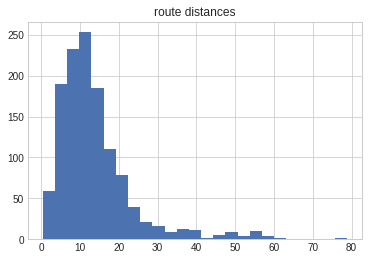

In [39]:
all_routes['distance'].hist(bins=25)
plt.title('route distances');

In [40]:
assert not all_routes.duplicated(['id', 'direction']).any()

In [41]:
assert all_routes['id'].max() < 10000

all_routes.loc[all_routes['direction'] == 2, 'id'] += 10000

all_routes.head(2)

,name,type,direction,stops,id,distance
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",11125,3.826103


In [42]:
assert all_routes['id'].nunique() == all_routes.shape[0]

In [43]:
assert all_routes.notna().all().all()

In [44]:
route_stops = set(chain.from_iterable(all_routes['stops']))
stops_ = set(all_stops['id'].unique())

missing_stops = route_stops - stops_

assert len(missing_stops) == 0

In [45]:
all_stops_json = [row.to_dict() for _, row in all_stops.iterrows()]

len(all_stops_json)

7661

In [46]:
save_json(all_stops_json, stops_fpath)

In [47]:
all_routes_json = [row.to_dict() for _, row in all_routes.iterrows()]

len(all_routes_json)

1253

In [48]:
save_json(all_routes_json, routes_fpath)